# Visualizing Government spending data with Pandas and Matplotlib

#### Jakub J.
#### 06.02. 2019

In this notebook I illustrate basic capabilities of python data driven libraries. 
It was your task I received which made me to rediscover the power of these libraries and julia/python/R notebooks.
It also seems more natural and effective compare to loading data into sqlite and then using excel to graph it in a long term.
Recently, I also learned about Dask, which could be used for heavier data sets and is build on pandas syntax for clusters.
Below is my code, it is definitely on heavy handed side but I plan to improve upon this. 
Presentation and math models could also be more advanced. I have some more code for market growth/decline but need to figure out how to plot it in a meaningful way and some other ideas.

Resources I used:

https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_sql.html
https://matplotlib.org/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py
https://www.theatlantic.com/science/archive/2018/04/the-scientific-paper-is-obsolete/556676/





In [68]:
import pandas as pd                    # data package
import matplotlib as mpl               # graphics package
import seaborn as sns                  # make prettier graphs (havent used here)
import datetime                        # probably not needed now
import sys
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

# This is an IPython command.  It puts plots here in the notebook, rather than  a separate window.
%matplotlib inline

# check versions
print('Python version:', sys.version)
print('Pandas version: ', pd.__version__)
print('Matplotlib version: ', mpl.__version__)
print('Today: ', dt.date.today())

Python version: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.23.0
Matplotlib version:  2.2.2
Today:  2019-02-07


In [69]:
#Load government data into dataframe
df = pd.read_csv('contracts.csv',error_bad_lines=False,delimiter=';')

#filter by keyword straven - some of description also have 'strav' abbreviation but there are only few.
#I could have done something like: If 'strav' but not 'Ostrava', then also include in the dataframe via regex. 

df = df.loc[df.Subject.str.contains("straven", na=False)]

In [70]:
#correct some of the data types

df['SupplierIC'] = df['SupplierIC'].apply(np.int64)
df['PublisherIC'] = df['PublisherIC'].apply(np.int64)
df['PublishedAtUtc'] =  pd.to_datetime(df['PublishedAtUtc'])

In [71]:
# I wanted to combine/merge two columns with price with vat and without vat so I can make some pie chart or graph based on market share
# so I created new column 'PricePaid at the end of the dataframe'

df['PricePaid']=df['ValueVatExcluded'].fillna(df['ValueVatIncluded'])
df = df.dropna(subset=['PricePaid'])
df['PricePaid'] = df['PricePaid'].apply(np.float64)

# I could save this and user later as original data set after triplechecking it's not distorted for whatever reason.
df.to_csv('filtered.csv') 



In [72]:
#After looking on Wikipedia for top 3 meal ticket companies I looked to their IC and 
#created three vars based on the company name, then summarized. This should be total amount the companies were paid by government

Sodexo = df.loc[df['SupplierIC'] == 61860476, 'PricePaid'].sum()
Edenred = df.loc[df['SupplierIC'] == 24745391, 'PricePaid'].sum()
Up = df.loc[df['SupplierIC'] == 62913671, 'PricePaid'].sum()

In [73]:
#create dictionary with these three variables

MarketShare = {'Company Name': ['Sodexo', 'EdenRed', 'UP'],
            'PaidTotal': [Sodexo, Edenred, Up]}

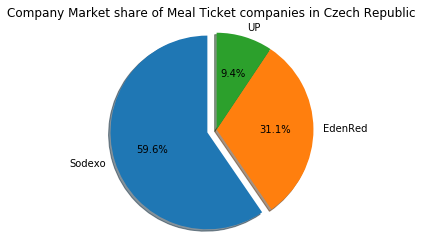

In [74]:
#Create simply pie chart based on sums from the file

PieChartTotal = pd.DataFrame(MarketShare, columns=['Company Name', 'PaidTotal'])
 
sizes = PieChartTotal['PaidTotal']  
labels = PieChartTotal['Company Name']
explode = (0.1, 0, 0)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.

ax1.axis('equal')

# https://cs.wikipedia.org/wiki/Stravenka

ax1.set_title("Company Market share of Meal Ticket companies in Czech Republic")
plt.show()


In [75]:
df.head()

,ContractId,VersionId,Subject,PublishedAtUtc,ValueVatExcluded,ValueVatIncluded,SupplierIC,SupplierName,PublisherIC,PricePaid
585,372237,396545,Objednávka stravenek - MSB,2016-10-14 10:51:07,NaN,218916,24745391,Edenred CZ s.r.o.,79481,218916.0
586,925849,1086469,Dodávka stravenek pro Katastrální pracoviště H...,2017-01-23 11:05:08,NaN,430000,24745391,Edenred CZ s.r.o.,71185208,430000.0
591,274745,294129,Objednávka stravenek - říjen 2016,2016-09-26 14:20:00,546217.0,NaN,24745391,Edenred CZ s.r.o.,215724,546217.0
592,723933,769365,Objednávka stravenek 12/2016 ÚzP v Benšově (A...,2016-12-07 07:52:01,73780.0,73780,24745391,Edenred CZ s.r.o.,72080043,73780.0
593,314685,336245,Objednávka stravenek za měsíc červen 2016,2016-10-04 16:14:10,NaN,132720,24745391,Edenred CZ s.r.o.,24449,132720.0


In [76]:
#Same done for Prague - we can see EdenRed is leading company as opposed global market share
#No new code just replacing with Prague

Prague = df.loc[df.Subject.str.contains("Praha", na=False)]
Sodexo_Pr = Prague.loc[Prague['SupplierIC'] == 61860476, 'PricePaid'].sum()
Edenred_Pr = Prague.loc[Prague['SupplierIC'] == 24745391, 'PricePaid'].sum()
Up_Pr = Prague.loc[Prague['SupplierIC'] == 62913671, 'PricePaid'].sum()

MarketSharePr = {'Company Name': ['Sodexo', 'EdenRed', 'Up'],
                   'PaidTotal': [Sodexo_Pr, Edenred_Pr, Up_Pr]}

PieChartPr = pd.DataFrame(MarketSharePr, columns=['Company Name', 'PaidTotal'])


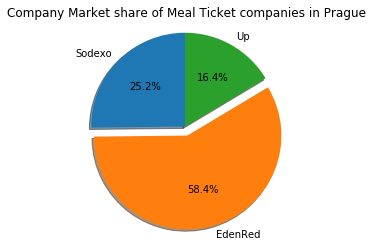

In [77]:
sizes = PieChartPr['PaidTotal']  
labels = PieChartPr['Company Name']
explode = (0, 0.1, 0)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')
# https://cs.wikipedia.org/wiki/Stravenka
ax1.set_title("Company Market share of Meal Ticket companies in Prague")
plt.show()

In [78]:
Prague.head()

,ContractId,VersionId,Subject,PublishedAtUtc,ValueVatExcluded,ValueVatIncluded,SupplierIC,SupplierName,PublisherIC,PricePaid
1188,5030043,5421195,Objednávka stravenek pro ZZS Praha-východ - du...,2018-05-02 11:09:09,NaN,70725,24745391,Edenred CZ s.r.o.,75030926,70725.0
2115,440757,469397,Objednávka stravenek Praha-východ - listopad 2016,2016-10-26 20:23:09,NaN,79850,24745391,Edenred CZ s.r.o.,75030926,79850.0
2728,1992734,2148218,stravenky Praha (AVISme 2017000254),2017-06-07 12:15:57,635120.0,635120,24745391,Edenred CZ s.r.o.,6947,635120.0
2943,725745,771293,Objednávka stravenek na 12/2016 ÚzP Praha-vých...,2016-12-07 09:47:23,57540.0,57540,24745391,Edenred CZ s.r.o.,72080043,57540.0
2954,724205,769657,Objednávka stravenek 12/2016 ÚzP Praha-západ (...,2016-12-07 08:13:57,144970.0,144970,24745391,Edenred CZ s.r.o.,72080043,144970.0


In [79]:
# Market share for Brno

Brno = df.loc[df.Subject.str.contains("Brno", na=False)]
Sodexo_Br = Brno.loc[Brno['SupplierIC'] == 61860476, 'PricePaid'].sum()
Edenred_Br = Brno.loc[Brno['SupplierIC'] == 24745391, 'PricePaid'].sum()
Up_Br = Brno.loc[Brno['SupplierIC'] == 62913671, 'PricePaid'].sum()

MarketShareBr = {'Company Name': ['Sodexo', 'EdenRed', 'Up'],
                   'PaidTotal': [Sodexo_Br, Edenred_Br, Up_Br]}

PieChartBr = pd.DataFrame(MarketShareBr, columns=['Company Name', 'PaidTotal'])


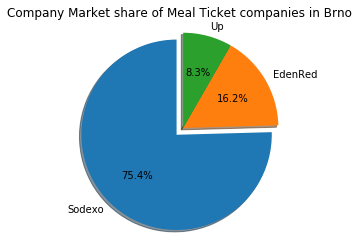

In [80]:
sizes = PieChartBr['PaidTotal']  
labels = PieChartBr['Company Name']
explode = (0.1, 0, 0)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')
# https://cs.wikipedia.org/wiki/Stravenka
ax1.set_title("Company Market share of Meal Ticket companies in Brno")
plt.show()

In [81]:
Brno.head()

,ContractId,VersionId,Subject,PublishedAtUtc,ValueVatExcluded,ValueVatIncluded,SupplierIC,SupplierName,PublisherIC,PricePaid
984,3710212,4002328,Nákup stravenek pro zaměstnance SOS 66 Brno za...,2017-12-06 15:32:59,278000.0,NaN,62913671,Up Česká republika s.r.o.,205,278000.0
3400,2621,2725,Nákup stravenek pro KS ČSÚ Brno - červenec 2016,2016-07-11 15:24:29,84181.0,101860,24745391,Edenred CZ s.r.o.,25593,84181.0
3529,526533,560661,"Nákup stravenek Brno, listopad 2016",2016-11-10 11:50:16,90585.0,90585,24745391,Edenred CZ s.r.o.,25593,90585.0
4405,2331490,2513754,Nákup stravenek pro zaměstnance SOS 66 Brno za...,2017-07-10 15:15:23,240000.0,NaN,62913671,Up Česká republika s.r.o.,205,240000.0
4435,4080504,4395144,Nákup stravenek pro zaměstnance SOS 66 Brno za...,2018-01-16 08:46:06,242000.0,NaN,62913671,Up Česká republika s.r.o.,205,242000.0


In [82]:
# Market share for ostrava

Ostrava = df.loc[df.Subject.str.contains("Ostrava", na=False)]
Sodexo_Os = Ostrava.loc[Ostrava['SupplierIC'] == 61860476, 'PricePaid'].sum()
Edenred_Os = Ostrava.loc[Ostrava['SupplierIC'] == 24745391, 'PricePaid'].sum()
Up_Os = Ostrava.loc[Ostrava['SupplierIC'] == 62913671, 'PricePaid'].sum()

MarketShareOs = {'Company Name': ['Sodexo', 'EdenRed', 'Up'],
                   'PaidTotal': [Sodexo_Os, Edenred_Os, Up_Os]}

PieChartOs = pd.DataFrame(MarketShareOs, columns=['Company Name', 'PaidTotal'])


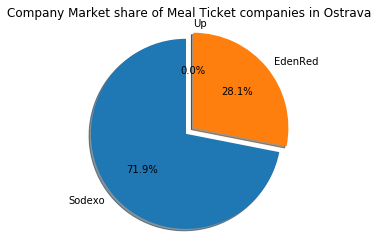

In [83]:
sizes = PieChartOs['PaidTotal']  
labels = PieChartOs['Company Name']
explode = (0.1, 0, 0)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')
# https://cs.wikipedia.org/wiki/Stravenka
ax1.set_title("Company Market share of Meal Ticket companies in Ostrava")
plt.show()

In [84]:
Ostrava.head()

,ContractId,VersionId,Subject,PublishedAtUtc,ValueVatExcluded,ValueVatIncluded,SupplierIC,SupplierName,PublisherIC,PricePaid
596,893057,950997,Objednávka_stravenky 1/2017_ÚzP Ostrava I (AV...,2017-01-04 10:46:19,235620.0,235620,24745391,Edenred CZ s.r.o.,72080043,235620.0
2178,584253,621673,Objednávka_stravenky 10/2016_ÚzP Ostrava III,2016-11-21 14:52:07,117450.0,117450,24745391,Edenred CZ s.r.o.,72080043,117450.0
2793,524705,776277,Objednávka_stravenky 08/2016_ÚzP Ostrava II (A...,2016-12-07 14:21:01,128160.0,128160,24745391,Edenred CZ s.r.o.,72080043,128160.0
2962,901933,960681,Objednávka_stravenky na 1/2017_ÚzP Ostrava II ...,2017-01-05 07:57:40,142870.0,142870,24745391,Edenred CZ s.r.o.,72080043,142870.0
2967,584209,621617,Objednávka_stravenky 09/2016_ÚzP Ostrava III,2016-11-21 14:50:32,106200.0,106200,24745391,Edenred CZ s.r.o.,72080043,106200.0
